## Imports

In [53]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.cluster import KMeans

## Load the Data

In [80]:
with open('shopping_trends.pkl', 'rb') as f:
       data = pickle.load(f)

In [82]:
data.head()

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Payment Method,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Preferred Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Credit Card,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Bank Transfer,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Cash,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,PayPal,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Cash,Free Shipping,Yes,Yes,31,PayPal,Annually


## Customer Segmentation Using K-Means Clustering

The k-means clustering algorithm is an Iterative algorithm that divides a group of n datasets into k different clusters based on the similarity and 
their mean distance from the centroid of that particular subgroup/ formed.

K, here is the pre-defined number of clusters to be formed by the algorithm. If K=3, It means the number of clusters to be formed from the dataset is 3.

In [88]:
# Select relevant columns for segmentation
df_segments = data[["Age", "Gender", "Purchase Amount (USD)", "Frequency of Purchases"]]

In [90]:
# Use one-hot encoding for categorical columns 'Gender' and 'Frequency of Purchases'
df_segments = pd.get_dummies(df_segments, columns=['Gender', 'Frequency of Purchases'], drop_first=True, dtype=int)

# Display the first few rows of the resulting DataFrame
df_segments.head()


,Age,Purchase Amount (USD),Gender_Male,Frequency of Purchases_Bi-Weekly,Frequency of Purchases_Every 3 Months,Frequency of Purchases_Fortnightly,Frequency of Purchases_Monthly,Frequency of Purchases_Quarterly,Frequency of Purchases_Weekly
0,55,53,1,0,0,1,0,0,0
1,19,64,1,0,0,1,0,0,0
2,50,73,1,0,0,0,0,0,1
3,21,90,1,0,0,0,0,0,1
4,45,49,1,0,0,0,0,0,0


In clustering algorithms like K-means, the number of clusters (K) is a crucial parameter that needs to be determined. Since the optimal value of K is 
often unknown, we rely on heuristic methods like the Within-Cluster-Sum-of-Squares (WCSS) method, also known as the elbow method.

The WCSS method aims to minimize the distance between data points and their respective cluster centroids. This is achieved by iteratively assigning 
data points to clusters and recomputing centroids until the sum of distances is minimized.

To determine the optimal number of clusters using the elbow method, follow these steps:

Perform K-means clustering on the dataset for different values of K, typically ranging from 1 to 10.
Calculate the WCSS for each value of K.
    
Create a graph plotting the WCSS values against the corresponding number of clusters (K).

Identify the elbow point, which is the sharp bend or "elbow" in the graph, indicating the optimal value of K.
    
The elbow point represents the point where the decrease in WCSS starts to diminish, suggesting that adding further clusters doesn't 
significantly improve the clustering quality. This point indicates the optimal number of clusters for the given dataset.

Let us apply the Elbow Method in action.

### Elbow Method 

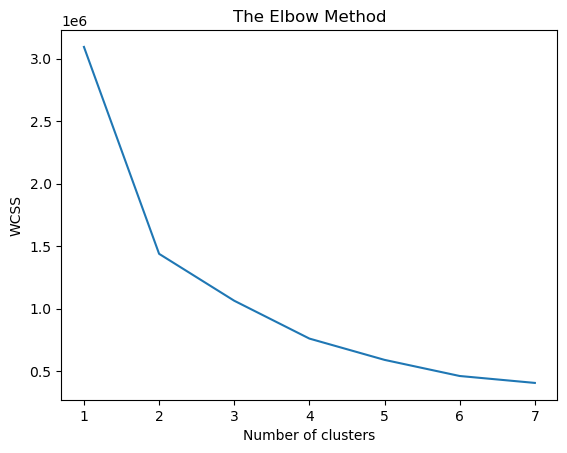

In [96]:
# Initialize an empty list to store the Within-Cluster-Sum-of-Squares (WCSS) for different cluster numbers
wcss = []

# Iterate over different numbers of clusters to find the optimal number
for i in range(1, 8):
    kmeans = KMeans(n_clusters=i)  # Create a KMeans instance with the current number of clusters
    kmeans.fit(df_segments)  # Fit the model to the data
    wcss_iter = kmeans.inertia_  # Get the WCSS for the current number of clusters
    wcss.append(wcss_iter)  # Append the WCSS to the list

# Create a line plot to visualize the Elbow Method
number_clusters = range(1, 8)
plt.plot(number_clusters, wcss)
plt.title('The Elbow Method')  # Set the title of the plot
plt.xlabel('Number of clusters')  # Set the label for the X-axis
plt.ylabel('WCSS')  # Set the label for the Y-axis

# Display the plot
plt.show()

This method shows that 3 is a good number of clusters.

In [99]:
# Create a KMeans instance with the desired number of clusters (in this case, 3)
kmeans = KMeans(n_clusters=3)

# Fit the KMeans model to the data and obtain cluster labels
kmeans.fit(df_segments)
cluster_labels = kmeans.predict(df_segments)

# Assign the cluster labels to a new column 'Clusters' in the DataFrame
df_segments['Clusters'] = cluster_labels

# Display the DataFrame with the added 'Clusters' column
df_segments

,Age,Purchase Amount (USD),Gender_Male,Frequency of Purchases_Bi-Weekly,Frequency of Purchases_Every 3 Months,Frequency of Purchases_Fortnightly,Frequency of Purchases_Monthly,Frequency of Purchases_Quarterly,Frequency of Purchases_Weekly,Clusters
0,55,53,1,0,0,1,0,0,0,0
1,19,64,1,0,0,1,0,0,0,2
2,50,73,1,0,0,0,0,0,1,1
3,21,90,1,0,0,0,0,0,1,1
4,45,49,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
3895,40,28,0,0,0,0,0,0,1,2
3896,52,49,0,1,0,0,0,0,0,0
3897,46,33,0,0,0,0,0,1,0,0
3898,44,77,0,0,0,0,0,0,1,1


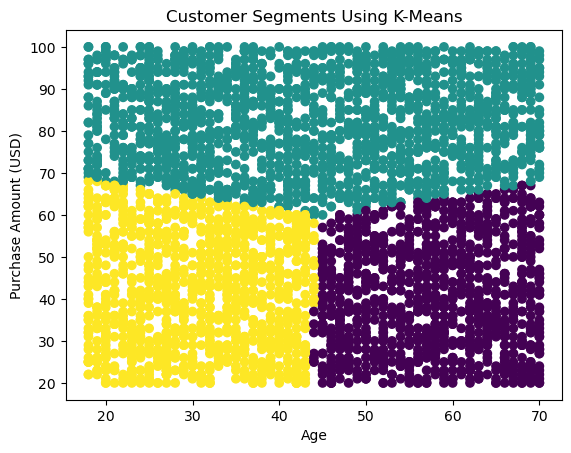

In [101]:
#visulizing clusters
plt.scatter(
    df_segments['Age'],  # X-axis: Age
    df_segments['Purchase Amount (USD)'],  # Y-axis: Purchase Amount (USD)
    c=kmeans.labels_,  # Color points by cluster labels assigned by KMeans
    cmap='viridis'  # Specify a color map for better visualization
)

plt.title('Customer Segments Using K-Means')
plt.xlabel('Age')
plt.ylabel('Purchase Amount (USD)')
plt.show()

K-means clustering revealed three distinct customer segments, represented by different color codes. Segment 1 comprises young customers with low
spending power, while Segment 2 consists of older customers with low average purchase amounts as well. In contrast, Segment 3 encompasses customers
with higher spending tendencies, often opting for more expensive items.

## Conclusion

Key Insights & Implications

Prioritize the 60-70 Age Group: This demographic represents the largest and fastest-growing customer segment, making it a prime target for marketing 
                                efforts. Businesses should consider developing products and services specifically tailored to their needs.

Nurture High-Spending Customers: A significant portion of customers make substantial purchases, indicating an opportunity to increase revenue 
                                from existing clients. Businesses should develop strategies to target and retain these high-value customers.

Target Women for Clothing and Accessories: Businesses selling clothing and accessories to women can potentially boost sales by focusing marketing and 
                                            sales strategies on this demographic.

Engage with Male Customers: Males tend to provide higher average review ratings than females, suggesting that targeting this demographic can enhance 
                            overall reputation.

Focus on Pennsylvania, Alaska, and Arizona: These states exhibit a clear preference for quality and style, indicating high-value customers with a 
                                           strong willingness to pay. Businesses should prioritize campaigns focused on these regions.

Tailor Marketing to Customer Segments: K-means clustering revealed three distinct customer segments: young low-spenders, older lowaverage-purchasers,
                                    and higher-spending value-conscious customers. Businesses should tailor their marketing strategies to address 
                                    the unique needs and preferences of each segment.